-----

# Prédiction d'un Indice Boursier - Exemple ML<a id="Top"></a>
-----

Sommaire Habituel: 

1. [Analyse de la problématique / du besoin](#A1) 
2. [Initialisation](#A2)
2. [AED - Analyse exploratoire des données](#A3)   
     a. [Data Analysis](#A3a)  
     b. [Data Cleaning / Data processing](#A3b)  
     c. [Sélection des Variables / Feature Engineering](#A3c) 
4. [Pré-traitement du jeu de données](#A4)
5. [Sélection et paramétrage optimal des modèles par validation croisée](#A5)
6. [Choix du Modèle et Interprétation](#A6)

(Tous les points n'ont pas traités en leurs entièretés)

----
### 1. Analyse de la problématique / du besoin <a id="A1"></a>
------------------------------------------

L'objectif de cet exemple est de prédire la tendance du CAC40 sur 1j utilisant les données de la veille.
Normalement je le traiterais comme un problème de classification :
   - 1 : tendance haussière  
   - -1 : tendance baissière 
   
Cependant vu que l'estimation du BE sera un exercice de régression, cet exemple suivra cette condition.

Nous prédirons donc le cours de clôture du CAC40 à 1j.

Cet exemple ne traite pas de l'hyperparamétrabilité des modèles, ni de la parallélisation des calculs par Spark.
Il n'a pour unique but d'aider à comprendre le déroulement global d'un projet de ML.


----
### 2. Initialisation <a id="A2"></a>
----
#### Importation des Librairies

In [99]:
#Traitement Données
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import *

#ML
import xgboost as xgb
from xgboost import plot_tree

from keras.models import Sequential
from keras.layers import Dense

#Data
from yahoo_finance import *

#Temps
import time
from datetime import datetime, timedelta
from datetime import date

#Plot
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline 

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import seaborn as sns
import ffn

#### Importation du jeu de Données

In [2]:
FCHI =pdr.get_data_yahoo(symbols='^FCHI', start=datetime(2015, 1, 1), end= date.today()- timedelta(1)) 
# Je ne veux pas importer la date d'aujourd'hui car en fonction de l'heure les variables ne sont pas 
# fixées et surtout c'est ce que l'on essaye de prédire.

In [164]:
df = FCHI # Copie du jeu de données

# Quick look
df = df.drop(columns=["Adj Close"]) # Suppression de la colonne Adjust Close qui est la 
                                    # valeur du close post clôture afin de réguler le prix, 
                                    # faisant quelques ajustement selon l'annonce de dividendes ... 
        
df = df.reset_index() # Réinitialisation de l'index comportant les date afin de l'avoir 
                      # en colonne et non en index, plus facile à traiter 

df.sort_index(axis = 0, ascending = False).head(10) # Affichage des 10 dernières valeurs de la bdd 
                                                    # dans unordre décroissant de date

,Date,High,Low,Open,Close,Volume
1151,2019-07-05,5616.629883,5573.350098,5613.919922,5593.720215,63896500
1150,2019-07-04,5629.790039,5613.029785,5622.799805,5620.729980,46168300
1149,2019-07-03,5618.810059,5579.040039,5579.240234,5618.810059,63296400
1148,2019-07-02,5582.910156,5556.759766,5578.379883,5576.819824,67572900
1147,2019-07-01,5611.279785,5567.910156,5584.129883,5567.910156,70651600
1146,2019-06-28,5545.060059,5486.279785,5491.169922,5538.970215,77991000
1145,2019-06-27,5511.220215,5465.620117,5508.379883,5493.609863,68458200
1144,2019-06-26,5531.450195,5497.220215,5504.669922,5500.720215,72145100
1143,2019-06-25,5523.569824,5499.649902,5499.819824,5514.569824,67601900
1142,2019-06-24,5547.109863,5514.140137,5534.350098,5521.709961,69081000


La variable cible, le Close, est explicitée par l'ensemble des autres variables.

----
### 3. AED - Analyse exploratoire des données <a id="A3"></a>
----
### 3.a  Data Analysis <a id="A3a"></a>

Vérification des types et de possible NA.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 6 columns):
Date      1152 non-null datetime64[ns]
High      1152 non-null float64
Low       1152 non-null float64
Open      1152 non-null float64
Close     1152 non-null float64
Volume    1152 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 54.1 KB


Aucune valeur manquante.

#### Stats Rapide

In [5]:
df.describe()

,High,Low,Open,Close,Volume
count,1152.000000,1152.000000,1152.000000,1152.000000,1.152000e+03
mean,4995.562985,4937.111563,4967.002510,4967.166866,9.939728e+07
std,395.021753,405.924844,400.329086,400.792512,3.568516e+07
min,3995.060059,3892.459961,3949.159912,3896.709961,0.000000e+00
25%,4660.640015,4584.137573,4614.015015,4616.274902,7.627158e+07
50%,5066.155029,4999.250000,5033.780029,5032.614990,9.286115e+07
75%,5337.902588,5290.080078,5312.399902,5312.757446,1.159316e+08
max,5657.439941,5628.930176,5637.939941,5640.100098,4.157757e+08


On voit quelques valeurs extrèmes dû à des conditions particulière ou à un mauvais reccueil des données qu'il va falloir Traiter/Supprimer :  
   - Volume = 0  
   - Volume max >> 75%
   
Nous allons voir par la suite si c'est réellement le cas.



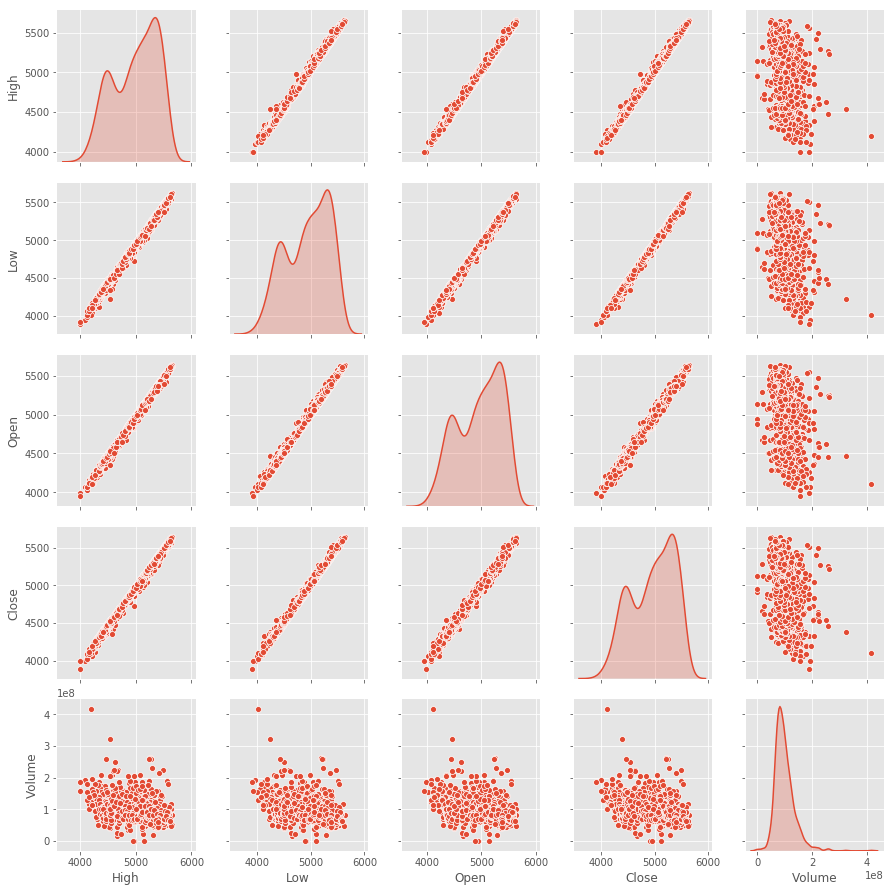

In [6]:
sns.pairplot(df,diag_kind="kde")

On remarque ques le High/Low/Open/Close sont left-skewed et le Volume right-skewed. Il faudra passer par une transformation.

#### Vue du Cours de Clôture  

In [175]:
data = []
data.append(go.Scatter(
        x = df['Date'].dt.strftime(date_format='%Y-%m-%d').values,
        y = df['Close'].values,
    ))
layout = go.Layout(dict(title = "Prix de Clôture du CAC40",
                  xaxis = dict(title = 'Date'),
                  yaxis = dict(title = 'Prix (€)'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

#### Vue du flux journalier

In [8]:
data = []
data.append(go.Bar(
        x = df['Date'].dt.strftime(date_format='%Y-%m-%d').values,
        y = (df["Volume"]*df["Close"]).values,
    ))
layout = go.Layout(dict(title = "Sommes des flux monétaire journalier",
                  xaxis = dict(title = 'Date'),
                  yaxis = dict(title = 'Volume Financier estimé (€)'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

#### Boxplot des Vars à la recherche de valeurs extrêmes

Text(0.5,1,'Volatilité')

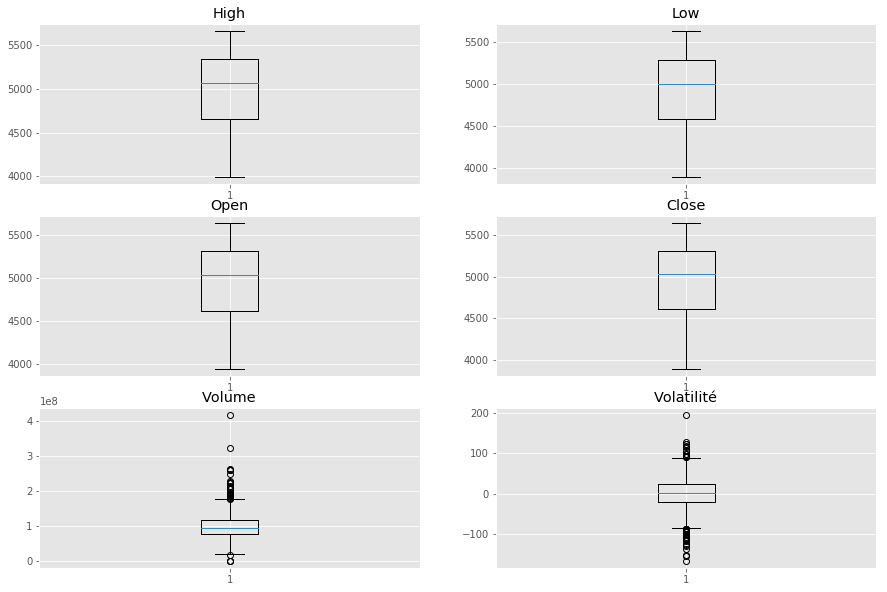

In [9]:
df['Volatilité'] = df['Close'] - df['Open']

f = plt.figure(figsize=(15,10))
ax = f.add_subplot(321)
ax2 = f.add_subplot(322)
ax3 = f.add_subplot(323)
ax4 = f.add_subplot(324)
ax5 = f.add_subplot(325)
ax6 = f.add_subplot(326)
ax.boxplot(df.High)
ax.set_title('High')
ax2.boxplot(df.Low)
ax2.set_title('Low')
ax3.boxplot(df.Open)
ax3.set_title('Open')
ax4.boxplot(df.Close)
ax4.set_title('Close')
ax5.boxplot(df.Volume)
ax5.set_title('Volume')
ax6.boxplot(df.Volatilité)
ax6.set_title('Volatilité')

On remarque quelques valeurs extrêmes dans le volume et volatilité.

### 3.b Data Cleaning / Data processing <a id="A3b"></a>


#### Vérification de la Volatilité

- #### Volatilité Négative

In [10]:
df.sort_values('Volatilité').head(10)

,Date,High,Low,Open,Close,Volume,Volatilité
236,2015-12-03,4975.709961,4730.209961,4895.640137,4730.209961,204118500,-165.430176
184,2015-09-22,4582.919922,4415.970215,4582.919922,4428.509766,158626000,-154.410156
280,2016-02-08,4220.850098,4046.639893,4217.450195,4066.310059,165143900,-151.140137
81,2015-04-29,5202.560059,5034.830078,5176.669922,5039.390137,149347400,-137.279785
102,2015-05-29,5144.729980,5006.459961,5137.020020,5007.890137,161991900,-129.129883
155,2015-08-12,5051.720215,4907.330078,5051.490234,4925.430176,148968600,-126.060059
1079,2019-03-22,5398.470215,5264.129883,5394.459961,5269.919922,109347500,-124.540039
1006,2018-12-06,4898.350098,4760.979980,4898.350098,4780.459961,140516600,-117.890137
637,2017-06-29,5272.939941,5143.819824,5268.229980,5154.350098,114605600,-113.879883
965,2018-10-10,5319.879883,5200.109863,5319.270020,5206.220215,104816300,-113.049805


03/12/2015 : Faux communiqué de la BCE sorti 'par erreur' avant l'heure officielle -immédiatement relayé par Twitter et les réseaux sociaux.
22/09/2015 : Scandale Volkswagen : Renault et PSA dévissent à la bourse de Paris.  
02/08/2015 : La Bourse de Paris a connu une nouvelle journée difficile, toujours pénalisée par les craintes d'un ralentissement de l'économie mondiale.
29/04/2015 : La Bourse de Paris accuse le coup, déçue par la croissance américaine.

Les valeurs 'extrêmes' étant justifiées et pouvant se reproduire, je décide donc des les laisser, d'autant plus qu'elles aideront à detecter des pics 'anormaux'.

- #### Volatilité Positive

In [11]:
df.sort_values('Volatilité',ascending = False).head(10)

,Date,High,Low,Open,Close,Volume,Volatilité
475,2016-11-09,4543.479980,4344.879883,4350.069824,4543.479980,204613400,193.410156
206,2015-10-22,4816.990234,4670.100098,4675.149902,4802.180176,154484900,127.030273
1138,2019-06-18,5516.060059,5376.120117,5386.379883,5509.729980,112114700,123.350098
354,2016-05-24,4440.649902,4300.419922,4309.299805,4431.520020,104153000,122.220215
271,2016-01-26,4366.649902,4224.450195,4238.850098,4356.810059,127614400,117.959961
287,2016-02-17,4238.330078,4112.040039,4119.350098,4233.470215,154374300,114.120117
881,2018-06-14,5543.290039,5408.299805,5420.390137,5528.459961,99909400,108.069824
164,2015-08-25,4596.240234,4431.830078,4458.089844,4564.859863,221636500,106.770020
110,2015-06-10,4956.740234,4811.540039,4831.029785,4934.910156,125031000,103.880371
976,2018-10-25,5033.520020,4925.560059,4933.950195,5032.299805,125445400,98.349609


La valeur extreme du 11 novembre 2016 s'explique par l'annonce de la victoire de Trump aux élections présidentielles Américaines.
Etant une valeur extrême, d'occurrence rarissime nous supprimons la valeur.

In [12]:
df = df.drop([475])
df.sort_values('Volatilité',ascending = False).head(2)

,Date,High,Low,Open,Close,Volume,Volatilité
206,2015-10-22,4816.990234,4670.100098,4675.149902,4802.180176,154484900,127.030273
1138,2019-06-18,5516.060059,5376.120117,5386.379883,5509.729980,112114700,123.350098


#### Vérification du Volume
- #### Volume Nul

In [13]:
df.sort_values('Volume').head(5)

,Date,High,Low,Open,Close,Volume,Volatilité
226,2015-11-19,4962.450195,4901.069824,4943.899902,4915.100098,0,-28.799805
654,2017-07-24,5143.479980,5094.359863,5133.680176,5127.700195,0,-5.979980
231,2015-11-26,4956.080078,4883.270020,4884.350098,4946.020020,0,61.669922
251,2015-12-24,4671.680176,4651.439941,4670.859863,4663.180176,16313800,-7.679688
1067,2019-03-06,5314.970215,5281.950195,5288.399902,5288.810059,18519200,0.410156


Mauvais reccueil des données, on complète les données par la moyenne de la colonnne.


In [14]:
df['Volume'] = df['Volume'].replace(0, np.mean(df['Volume']))

In [15]:
df.loc[(226,654,231),:]

,Date,High,Low,Open,Close,Volume,Volatilité
226,2015-11-19,4962.450195,4901.069824,4943.899902,4915.100098,9.930587e+07,-28.799805
654,2017-07-24,5143.479980,5094.359863,5133.680176,5127.700195,9.930587e+07,-5.979980
231,2015-11-26,4956.080078,4883.270020,4884.350098,4946.020020,9.930587e+07,61.669922


- #### Volume Elevé

In [16]:
df.sort_values('Volume',ascending=False).head(15)

,Date,High,Low,Open,Close,Volume,Volatilité
377,2016-06-24,4198.899902,4007.969971,4114.580078,4106.729980,415775700.0,-7.850098
163,2015-08-24,4540.129883,4230.490234,4465.479980,4383.459961,323292800.0,-82.020020
70,2015-04-14,5260.779785,5192.890137,5252.479980,5218.060059,262666600.0,-34.419922
693,2017-09-15,5237.169922,5201.970215,5220.890137,5213.910156,259691200.0,-6.979980
71,2015-04-15,5269.500000,5217.040039,5230.979980,5254.350098,259448500.0,23.370117
309,2016-03-18,4472.729980,4418.490234,4452.040039,4462.509766,259017000.0,10.469727
182,2015-09-18,4623.100098,4495.049805,4623.100098,4535.850098,248859900.0,-87.250000
590,2017-04-24,5295.470215,5228.540039,5267.879883,5268.850098,228792800.0,0.970215
476,2016-11-10,4606.660156,4502.740234,4577.009766,4530.950195,225207100.0,-46.059570
15,2015-01-23,4673.299805,4585.640137,4588.490234,4640.689941,222514400.0,52.199707


24/06/16 : Annonce du Brexit.  
24/08/15 : https://www.lemonde.fr/economie-mondiale/article/2015/08/24/la-bourse-de-shanghai-entraine-les-places-asiatiques-dans-sa-chute_4734743_1656941.html

In [17]:
df = df.drop([377,163])
df.sort_values('Volume',ascending=False).head(5)

,Date,High,Low,Open,Close,Volume,Volatilité
70,2015-04-14,5260.779785,5192.890137,5252.479980,5218.060059,262666600.0,-34.419922
693,2017-09-15,5237.169922,5201.970215,5220.890137,5213.910156,259691200.0,-6.979980
71,2015-04-15,5269.500000,5217.040039,5230.979980,5254.350098,259448500.0,23.370117
309,2016-03-18,4472.729980,4418.490234,4452.040039,4462.509766,259017000.0,10.469727
182,2015-09-18,4623.100098,4495.049805,4623.100098,4535.850098,248859900.0,-87.250000


----
### 3.b Sélection des Variables / Feature Engineering <a id="A3b"></a>
----

### Décalage des Données

Afin de prédire le close du lendemain il faut que, lors de l'entrainement, le close soit lié aux autres variables à la période précédente, cela devient donc :   
- Date : reste la même car on veut savoir sur quel jour on prédit;
- High-1;
- Low-1;
- Open-1;
- Close;
- Volume-1.

In [18]:
df = df.drop(columns=["Volatilité"])
df.head()

,Date,High,Low,Open,Close,Volume
0,2015-01-02,4311.000000,4224.339844,4294.049805,4252.290039,69809300.0
1,2015-01-05,4276.919922,4105.450195,4221.990234,4111.359863,137887700.0
2,2015-01-06,4151.410156,4076.159912,4129.890137,4083.500000,130814400.0
3,2015-01-07,4144.950195,4080.780029,4111.729980,4112.729980,121316600.0
4,2015-01-08,4270.109863,4163.629883,4176.160156,4260.189941,154417100.0


In [19]:
liste_column_reculer = ['High','Low','Open','Volume']

for i in liste_column_reculer :
    df[i] = df[i].shift(-1)

In [20]:
df.head()
df = df.rename(index=str, columns={"High": "High J-1", "Low": "Low J-1",'Open':'Open J-1','Volume':'Volume J-1'})


- ### Ajout des Variables des jours précédents (J-2,J-5,J-10)

In [21]:
liste_jours = [1,4,9]

df['Close J-1'] = df.Close.shift(-1)

for i in liste_jours:
    df['Close J-'+str(i+1)] = df['Close J-1'].shift(-i)     #Car on a déja décalé par 1
    df['Open J-'+str(i+1)] = df['Open J-1'].shift(-i)       #Car on a déja décalé par 1
    df['Low J-'+str(i+1)] = df['Low J-1'].shift(-i)         #Car on a déja décalé par 1
    df['High J-'+str(i+1)] = df['High J-1'].shift(-i)       #Car on a déja décalé par 1
    df['Volume J-'+str(i+1)] = df['Volume J-1'].shift(-i)   #Car on a déja décalé par 1
    

In [22]:
df = df[['Date','Close','Low J-1','High J-1','Open J-1','Close J-1','Volume J-1','Low J-2','High J-2','Open J-2','Close J-2','Volume J-2','Low J-5','High J-5','Open J-5','Close J-5','Volume J-5','Low J-10','High J-10','Open J-10','Close J-10','Volume J-10']]
df.head(6)

,Date,Close,Low J-1,High J-1,Open J-1,Close J-1,Volume J-1,Low J-2,High J-2,Open J-2,...,Low J-5,High J-5,Open J-5,Close J-5,Volume J-5,Low J-10,High J-10,Open J-10,Close J-10,Volume J-10
0,2015-01-02,4252.290039,4105.450195,4276.919922,4221.990234,4111.359863,137887700.0,4076.159912,4151.410156,4129.890137,...,4149.140137,4272.830078,4249.259766,4179.069824,139011800.0,4294.759766,4387.220215,4303.549805,4379.620117,174122800.0
1,2015-01-05,4111.359863,4076.159912,4151.410156,4129.890137,4083.500000,130814400.0,4080.780029,4144.950195,4111.729980,...,4165.149902,4252.270020,4196.779785,4228.240234,129743900.0,4367.240234,4423.250000,4388.669922,4394.930176,107393400.0
2,2015-01-06,4083.500000,4080.780029,4144.950195,4111.729980,4112.729980,121316600.0,4163.629883,4270.109863,4176.160156,...,4197.810059,4310.580078,4204.770020,4290.279785,127789000.0,4405.939941,4463.509766,4406.959961,4446.020020,141375600.0
3,2015-01-07,4112.729980,4163.629883,4270.109863,4176.160156,4260.189941,154417100.0,4149.140137,4272.830078,4249.259766,...,4207.370117,4302.220215,4227.459961,4223.240234,156380800.0,4406.720215,4484.819824,4455.009766,4484.819824,160196600.0
4,2015-01-08,4260.189941,4149.140137,4272.830078,4249.259766,4179.069824,139011800.0,4165.149902,4252.270020,4196.779785,...,4119.350098,4338.729980,4262.939941,4323.200195,187411300.0,4462.169922,4569.549805,4486.759766,4552.799805,208073500.0
5,2015-01-09,4179.069824,4165.149902,4252.270020,4196.779785,4228.240234,129743900.0,4197.810059,4310.580078,4204.770020,...,4294.759766,4387.220215,4303.549805,4379.620117,174122800.0,4585.640137,4673.299805,4588.490234,4640.689941,222514400.0


- ### Ajout d'indicateurs de Tendance ( CCI, MACD, ...)
----
#### Commodity Channel Index (CCI)
---

The commodity channel index (CCI) is an oscillator which was originally introduced by Donald Lambert in 1980. CCI can be used to identify cyclical turns across asset classes, be it commodities, indices, stocks, or ETFs. CCI is also used by traders to identify overbought/oversold levels for securities.

The CCI looks at the relationship between price and a moving average.

Computing the typical price for the security. Typical price is obtained by the averaging the high, low and the close price for the day.
Finding the moving average for the chosen number of days based on the typical price.
Computing the standard deviation for the same period as that used for the MA.
The formula for CCI is given by:

$$CCI = \frac{Price~–~SMA(Price)}{0.015~*~MAD(Price)}$$

The index is scaled by an inverse factor of 0.015 to provide for more readable numbers.


CCI can be used to determine overbought and oversold levels. Readings above +100 can imply an overbought condition, while readings below −100 can imply an oversold condition. However, one should be careful because a security can continue moving higher after the CCI indicator becomes overbought. Likewise, securities can continue moving lower after the indicator becomes oversold.

Whenever the security is in overbought/oversold levels as indicated by the CCI, there is a good chance that the price will see corrections. Hence a trader can use such overbought/oversold levels to enter in short/long positions.

Traders can also look for divergence signals to take suitable positions using CCI. A bullish divergence occurs when the underlying security makes a lower low and the CCI forms a higher low, which shows less downside momentum. Similarly, a bearish divergence is formed when the security records a higher high and the CCI forms a lower high, which shows less upside momentum.

In [23]:
liste_jours = [1,2,5,10]
# Calcul du Prix Moyen

for i in liste_jours:
    df['Avr_Price J-'+str(i)] = (df['Low J-'+str(i)]+df['High J-'+str(i)]+df['Close J-'+str(i)])/3

In [24]:
def CCI(data, period = 200, treshold = 100, short = 0.0):
    moving_average_data = data.rolling(period).mean()
    moving_average_absolute_deviation = data.mad()
    CCI = (data - moving_average_data)/(moving_average_absolute_deviation*0.015)
    
    return CCI


for i in liste_jours:
    df['CCI J-'+str(i)] = CCI(df['Avr_Price J-'+str(i)])

#### Moving Average Convergence Divergence (MACD)
----

First of all let's introduce the Exponential Moving Average (EMA), defined as : 

$$EMA(t) = (1-\alpha) \cdot EMA \cdot \alpha \cdot p(t)$$
$$EMA(0) = p(t_{0})$$

where $ p(t) $ is the price at time $ t $ and $ \alpha $ is called the decay parameter for the EMA. 

$ \alpha $ is related to the lag as 

* $$ \alpha = \frac{1}{L + 1} $$

and the length of the window (span) $ M $ as

* $$ \alpha = \frac{2}{M + 1} $$

-------
#### MACD Signal | MACD Difference
Moving Average Convergence Divergence is a trading indicator that focuses on exponential moving average (EMA). 
To calculate it we use:

$$MACD = EMA(n1, close) — EMA(n2, close) $$

$$MACD_{Signal} = EMA(n3, MACD) $$

$$MACD_{Difference} = MACD — MACD_{Signal} $$

*The typical values for the variables are n1 = 12, n2 = 26 and n3 = 9 periods, but they can be change depending on your trading style and goals.*

In [25]:
ema_short = df.Close.ewm(span = 12, adjust=False).mean()
ema_long = df.Close.ewm(span= 26, adjust=False).mean()
    
MACD = ema_short - ema_long
MACD_signal = MACD.ewm(span = 9, adjust=False).mean()
MACD_diff = MACD - MACD_signal
    
df['MACD'] = MACD_diff
for i in liste_jours:
    df['MACD J-'+str(i)] = df['MACD'].shift(-i)

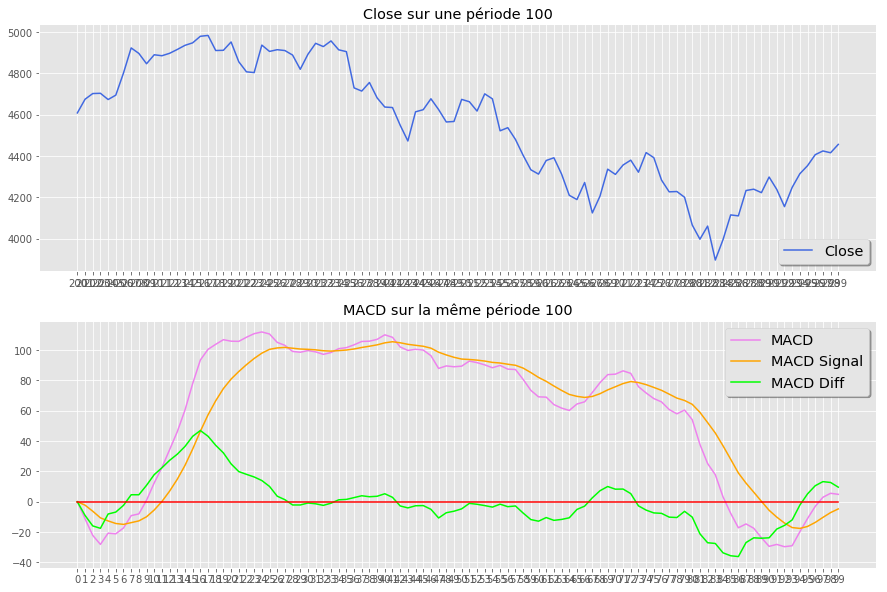

In [90]:
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(211)
ax2 = f.add_subplot(212)
ax.plot(df.Close[:100],'royalblue',label = 'Close')
ax.set_title('Close sur une période 100')
ax.legend(loc='lower right', shadow=True, fontsize='x-large')
ax2.plot(MACD[:100],'violet',label = 'MACD')
ax2.plot(MACD_signal[:100],'orange',label = 'MACD Signal')
ax2.plot(MACD_diff[:100],'lime',label = 'MACD Diff')
ax2.set_title('MACD sur la même période 100')
ax2.plot(np.linspace(0,0, 100),'r')
ax2.legend(loc='upper right', shadow=True, fontsize='x-large')


The theory tells us that when the MACD curve (blue) is smaller than the MACD_Signal (orange) or when the MACD difference (green curve) has a value lower than 0, the price trend will be bearish. On the contrary, it indicates a price increase.

In [27]:
df = df.drop(columns=["MACD"])
# On enleve la column MACD lié au close au jours J car il n'est pas possible 
# de le calculer et donc de le mettre en données d'entrée des prédictions
# Car en effet dans son calcul il nécessite le Close du jour.


#### The Bollinger Bands
---
The concept of Bollinger bands was developed by John Bollinger. These bands comprise of an upper Bollinger band and a lower Bollinger band and are placed two standard deviations above and below a moving average.

Bollinger bands expand and contract based on the volatility. During a period of rising volatility, the bands widen, and they contract as the volatility decreases. Prices are considered to be relatively high when they move above the upper band and relatively low when they go below the lower band.


The Bollinger Bands are used to analyze the volatility of the price for an asset in a specific period of time. There are 3 bands, the Middle Band (MB) is the average of the price in the last n periods, the Upper (UB) and Lower Bands (LB) are equal to the middle band, but adding or subtracting x times the standard deviation.

$$MB = SMA(n,Close)$$

$$UB = MB + (x * STD(n,Close)$$

$$LB = MB — (x * STD(n,Close)$$

*The normal parameters that are being used are n = 20 periods and x = 2.*

In [28]:
MB = df.Close.rolling(20).mean()
UB = MB + 2 * df.Close.rolling(20).std()
LB = MB - 2 * df.Close.rolling(20).std()

df['Middle Band'] = MB
df['Upper Band'] = UB
df['Lower Band'] = LB
for i in liste_jours:
    df['Middle Band J-'+str(i)] = df['Middle Band'].shift(-i)
    df['Upper Band J-'+str(i)] = df['Upper Band'].shift(-i)
    df['Lower Band J-'+str(i)] = df['Lower Band'].shift(-i)

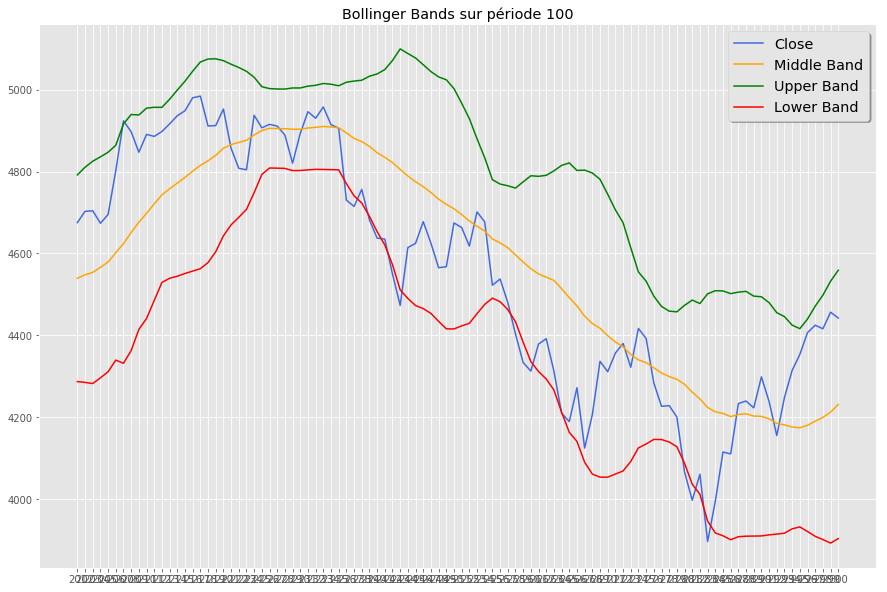

In [29]:
plt.figure(figsize=(15,10))
plt.plot(df.Close[200:300],'royalblue')
plt.plot(df['Middle Band'][200:300],'orange',label = 'Middle Band')
plt.plot(df['Upper Band'][200:300],'g',label = 'Upper Band')
plt.plot(df['Lower Band'][200:300],'r',label = 'Lower Band')
plt.title('Bollinger Bands sur période 100')
plt.legend(loc='upper right', shadow=True, fontsize='x-large')

If we take a look at the second plot, when the closing wave (blue) surpasses the upper (green) or lower (red) bands, there are sudden changes in the price, and it is usually a good idea to sell when it is higher than the Upper Band and to buy when it is lower than the Lower Band.

In [30]:
df = df.drop(columns=['Middle Band'])
df = df.drop(columns=['Upper Band'])
df = df.drop(columns=['Lower Band'])

# Pour la même raison que le MACD nous supprimons UB,MB et LB.


#### Relative Strength Index (RSI)
---
La formule classique du RSI est la suivante :
$$ RSI = 100 - \frac{100}{1 + \frac{H}{B}} $$


Avec

- H qui est la moyenne des hausses pendant les X dernières Unités de Temps (UT).

- B qui est la moyenne des baisses pendant les X dernières Unités de Temps (UT).


Le RSI indique un un chiffre compris entre 0 et 100.



Interprétation :

- Un RSI 50 indique que la marché trouve un point d'équilibre sur l'Unité de Temps que vous tradez.

- Si vous utilisez un RSI 25 sur un graphique en 1 journée : le chiffre du RSI correspondra à la moyenne des 25 derniers jours (25*1=25). (donc si vous achetez, c'est que vous êtes prêt à investir entre 1 et 25 jours);

- Lorsque le RSi est supérieur à 70, le marché est dit sur-acheté et il est candidat à une correction baissière (c'est une possibilité, pas une certitude) dans votre unité de temps;

- Lorsque le RSI est inférieur à 30, le marché est dit sur-vendu et il est candidat à une correction à la hausse (là encore c'est une possibilité, pas une certitude) dans votre unité de temps.

In [91]:
def RSI(Close, n=14):
    
    deltas = np.diff(Close)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(Close)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(Close)):
        delta = deltas[i-1] # ca la diff est de 1 plus petit

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

df['RSI_5'] = RSI(df['Close'].values, 5)   #Sur une semaine de jours ouvrés
df['RSI_10'] = RSI(df['Close'].values, 10) #Sur 2 semaines de jours ouvrés

for i in liste_jours:
    df['RSI_5 J-'+str(i)] = df['RSI_5'].shift(-i)
    df['RSI_10 J-'+str(i)] = df['RSI_10'].shift(-i)

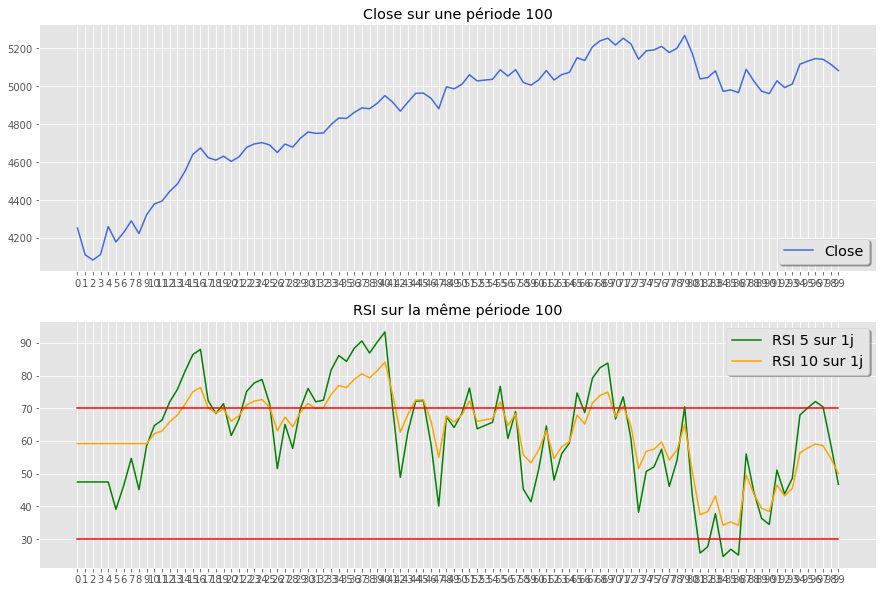

In [32]:
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(211)
ax2 = f.add_subplot(212)
ax.plot(df.Close[:100],'royalblue',label='Close')
ax.set_title('Close sur une période 100')
ax.legend(loc='lower right', shadow=True, fontsize='x-large')
ax2.plot(df['RSI_5'][:100],'green',label='RSI 5 sur 1j')
ax2.plot(df['RSI_10'][:100],'orange',label='RSI 10 sur 1j')
ax2.plot(np.linspace(70,70, 100),'r')
ax2.plot(np.linspace(30,30, 100),'r')
ax2.set_title('RSI sur la même période 100')
ax2.legend(loc='upper right', shadow=True, fontsize='x-large')

In [33]:
# De nouveau
df = df.drop(columns=['RSI_5'])
df = df.drop(columns=['RSI_10'])

- ### Matrice de Corrélation
---

<module 'matplotlib.pyplot' from '/Users/yoan/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

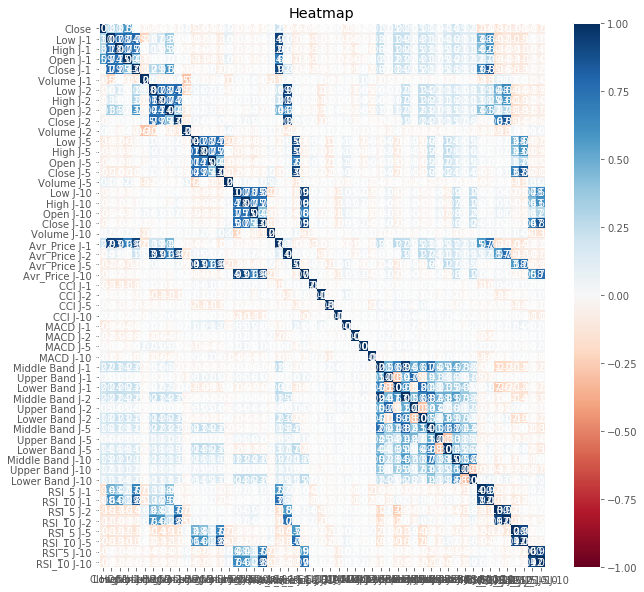

In [34]:
df.drop(columns=["Date"]).to_returns().plot_corr_heatmap(figsize=(10, 10))

Je me serais attendu à plus de corrélation entre le Close et le CCI,MACD, Bollinger et bcp moins entre les UB,MB,LB.

On remarque une redondance dans la correlation entre le High/Low/Open/Close selon les jours, ce qui est normal.
Il serait interessant de tester le fait de supprimer de notre modèle plusieurs de ces variables pour n'en garder que une.

----
### 4. Pré-traitement du jeu de données <a id="A4"></a>
-----
#### Suppression des lignes contenant un NA

Suite au calcul, notamment du CCI de multiple lignes comportent un NA devant être supprimés. Cependant j'avais anticipé cela en prennant une période de temps suffisamment grande.

In [35]:
df = df[['Date','Close',
         'Low J-1','High J-1','Open J-1','Close J-1','Volume J-1','Avr_Price J-1','CCI J-1','MACD J-1','Lower Band J-1',
         'Middle Band J-1','Upper Band J-1','RSI_5 J-1','RSI_10 J-1',
         'Low J-2','High J-2','Open J-2','Close J-2','Volume J-2','Avr_Price J-2','CCI J-2','MACD J-2','Lower Band J-2',
         'Middle Band J-2','Upper Band J-2','RSI_5 J-2','RSI_10 J-2',
         'Low J-5','High J-5','Open J-5','Close J-5','Volume J-5','Avr_Price J-5','CCI J-5','MACD J-5','Lower Band J-5',
         'Middle Band J-5','Upper Band J-5','RSI_5 J-5','RSI_10 J-5',
         'Low J-10','High J-10','Open J-10','Close J-10','Volume J-10','Avr_Price J-10','CCI J-10','MACD J-10','Lower Band J-10',
         'Middle Band J-10','Upper Band J-10','RSI_5 J-10','RSI_10 J-10']]

df.head()

,Date,Close,Low J-1,High J-1,Open J-1,Close J-1,Volume J-1,Avr_Price J-1,CCI J-1,MACD J-1,...,Close J-10,Volume J-10,Avr_Price J-10,CCI J-10,MACD J-10,Lower Band J-10,Middle Band J-10,Upper Band J-10,RSI_5 J-10,RSI_10 J-10
0,2015-01-02,4252.290039,4105.450195,4276.919922,4221.990234,4111.359863,137887700.0,4164.576660,NaN,-8.993835,...,4379.620117,174122800.0,4353.866699,NaN,17.887477,NaN,NaN,NaN,64.706043,62.233198
1,2015-01-05,4111.359863,4076.159912,4151.410156,4129.890137,4083.500000,130814400.0,4103.690023,NaN,-15.916977,...,4394.930176,107393400.0,4395.140137,NaN,22.386157,NaN,NaN,NaN,66.387762,63.065056
2,2015-01-06,4083.500000,4080.780029,4144.950195,4111.729980,4112.729980,121316600.0,4112.820068,NaN,-17.499708,...,4446.020020,141375600.0,4438.489909,NaN,27.291140,NaN,NaN,NaN,71.960741,65.853728
3,2015-01-07,4112.729980,4163.629883,4270.109863,4176.160156,4260.189941,154417100.0,4231.309896,NaN,-8.067158,...,4484.819824,160196600.0,4458.786621,NaN,31.347135,NaN,NaN,NaN,75.773851,67.898911
4,2015-01-08,4260.189941,4149.140137,4272.830078,4249.259766,4179.069824,139011800.0,4200.346680,NaN,-6.793971,...,4552.799805,208073500.0,4528.173177,NaN,36.449143,NaN,NaN,NaN,81.333399,71.251036


In [176]:
df = df.dropna() # Suppression des lignes comportant un NA.

In [37]:
df.head()

,Date,Close,Low J-1,High J-1,Open J-1,Close J-1,Volume J-1,Avr_Price J-1,CCI J-1,MACD J-1,...,Close J-10,Volume J-10,Avr_Price J-10,CCI J-10,MACD J-10,Lower Band J-10,Middle Band J-10,Upper Band J-10,RSI_5 J-10,RSI_10 J-10
200,2015-10-14,4609.029785,4622.450195,4683.750000,4651.770020,4675.290039,113311300.0,4660.496745,-35.736619,27.131660,...,4890.580078,110846300.0,4882.306641,2.432810,28.367573,4441.251299,4698.018506,4954.785713,70.300537,67.409331
201,2015-10-15,4675.290039,4680.220215,4718.910156,4702.560059,4702.790039,108928800.0,4700.640137,-28.422699,26.533354,...,4885.819824,188704100.0,4875.683268,0.608548,25.177015,4485.147350,4720.982495,4956.817640,68.705140,66.718425
202,2015-10-16,4702.790039,4684.520020,4744.970215,4697.520020,4704.069824,88461400.0,4711.186686,-26.956703,24.916978,...,4897.660156,122869800.0,4890.660156,3.078311,22.144423,4529.144776,4742.921509,4956.698242,70.767746,67.635201
203,2015-10-19,4704.069824,4649.979980,4711.950195,4708.189941,4673.810059,93237900.0,4678.580078,-33.874762,20.677656,...,4916.209961,113864200.0,4899.393392,4.348576,19.747527,4539.401579,4757.887012,4976.372445,74.109464,69.116097
204,2015-10-20,4673.810059,4642.939941,4716.569824,4691.370117,4695.100098,104452800.0,4684.869954,-33.089532,18.259214,...,4936.180176,106982700.0,4922.733398,8.502021,17.920360,4544.423898,4771.664014,4998.904129,77.561358,70.718759


#### Split du Jeu de données en Train / Test

2/3 Train  
1/3 Test  

In [38]:
split = int(df.shape[0] *2/3)


X_train = df.drop(columns=['Close','Date'])[0:split]
X_test = df.drop(columns=['Close','Date'])[split+1:]
y_train = df['Close'][0:split]
y_test = df['Close'][split+1:]

In [39]:
X_train.head()

,Low J-1,High J-1,Open J-1,Close J-1,Volume J-1,Avr_Price J-1,CCI J-1,MACD J-1,Lower Band J-1,Middle Band J-1,...,Close J-10,Volume J-10,Avr_Price J-10,CCI J-10,MACD J-10,Lower Band J-10,Middle Band J-10,Upper Band J-10,RSI_5 J-10,RSI_10 J-10
200,4622.450195,4683.750000,4651.770020,4675.290039,113311300.0,4660.496745,-35.736619,27.131660,4287.231058,4539.533008,...,4890.580078,110846300.0,4882.306641,2.432810,28.367573,4441.251299,4698.018506,4954.785713,70.300537,67.409331
201,4680.220215,4718.910156,4702.560059,4702.790039,108928800.0,4700.640137,-28.422699,26.533354,4285.256340,4547.880005,...,4885.819824,188704100.0,4875.683268,0.608548,25.177015,4485.147350,4720.982495,4956.817640,68.705140,66.718425
202,4684.520020,4744.970215,4697.520020,4704.069824,88461400.0,4711.186686,-26.956703,24.916978,4282.402719,4553.808496,...,4897.660156,122869800.0,4890.660156,3.078311,22.144423,4529.144776,4742.921509,4956.698242,70.767746,67.635201
203,4649.979980,4711.950195,4708.189941,4673.810059,93237900.0,4678.580078,-33.874762,20.677656,4296.343745,4566.073511,...,4916.209961,113864200.0,4899.393392,4.348576,19.747527,4539.401579,4757.887012,4976.372445,74.109464,69.116097
204,4642.939941,4716.569824,4691.370117,4695.100098,104452800.0,4684.869954,-33.089532,18.259214,4311.236912,4579.187012,...,4936.180176,106982700.0,4922.733398,8.502021,17.920360,4544.423898,4771.664014,4998.904129,77.561358,70.718759


In [40]:
y_train.head()

200    4609.029785
201    4675.290039
202    4702.790039
203    4704.069824
204    4673.810059
Name: Close, dtype: float64

In [41]:
X_test.head()

,Low J-1,High J-1,Open J-1,Close J-1,Volume J-1,Avr_Price J-1,CCI J-1,MACD J-1,Lower Band J-1,Middle Band J-1,...,Close J-10,Volume J-10,Avr_Price J-10,CCI J-10,MACD J-10,Lower Band J-10,Middle Band J-10,Upper Band J-10,RSI_5 J-10,RSI_10 J-10
829,5118.689941,5171.620117,5144.629883,5152.120117,81857300.0,5147.476725,-27.233182,-4.399433,5067.876764,5198.298999,...,5312.959961,60319200.0,5311.436686,4.530609,19.457471,5056.907463,5217.743530,5378.579598,70.249261,62.277083
830,5094.689941,5163.629883,5155.470215,5141.799805,91113200.0,5133.373210,-29.861585,-2.918329,5064.845918,5197.027490,...,5353.540039,81726700.0,5346.963379,11.384986,20.353649,5051.553568,5221.283032,5391.012496,79.172640,67.228242
831,5213.629883,5280.609863,5216.680176,5276.669922,94689000.0,5256.969889,-5.720465,7.089260,5066.199272,5202.349487,...,5380.169922,82529900.0,5373.846680,16.503256,21.515760,5045.133854,5229.149536,5413.165219,83.285100,70.090596
832,5243.020020,5282.720215,5256.250000,5258.240234,68854400.0,5261.326823,-4.865454,12.117076,5067.674658,5205.869995,...,5391.640137,74094100.0,5388.863281,19.231529,21.767139,5038.367165,5236.110034,5433.852903,84.891325,71.290665
833,5247.569824,5289.720215,5271.000000,5263.390137,60670000.0,5266.893392,-3.743434,15.237277,5067.396134,5206.334497,...,5412.830078,87342700.0,5406.576660,22.470353,22.005189,5031.788401,5244.764526,5457.740651,87.635166,73.475235


In [42]:
y_test.head()

829    5167.299805
830    5152.120117
831    5141.799805
832    5276.669922
833    5258.240234
Name: Close, dtype: float64

#### Scale du Jeu de données en Train / Test

In [43]:
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler

scalarX, scalarY = MinMaxScaler(), MinMaxScaler()
scalarX.fit(X_test)
scalarY.fit(y_train.values.reshape(y_train.shape[0],1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [44]:
X_train = scalarX.transform(X_train)
X_test = scalarX.transform(X_test)

#Transformation uniquement valable pour Keras
y_train_Keras = scalarY.transform(y_train.values.reshape(y_train.shape[0],1))
y_test_Keras =  scalarY.transform(y_test.values.reshape(y_test.shape[0],1))


----
### 5. Sélection et paramétrage optimal des modèles par validation croisée <a id="A5"></a>
-----

Implémentation des modèles "basiques".


- ### NN Keras

Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation.

In [121]:
# Keras Model
model = Sequential()
model.add(Dense(52, input_dim=52, activation='relu'))
model.add(Dense(52, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])
model.summary()

Start_Keras = datetime.now()
history = model.fit(X_train, y_train_Keras, epochs=15, batch_size=30,validation_split=0.3)
Temps_Keras = datetime.now() - Start_Keras


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 52)                2756      
_________________________________________________________________
dense_24 (Dense)             (None, 52)                2756      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 53        
Total params: 5,565
Trainable params: 5,565
Non-trainable params: 0
_________________________________________________________________
Train on 438 samples, validate on 188 samples
Epoch 1/15
438/438 [==============================] - 1s 3ms/step - loss: 0.0513 - acc: 0.0023 - val_loss: 0.0150 - val_acc: 0.0053
Epoch 2/15
438/438 [==============================] - 0s 110us/step - loss: 0.0099 - acc: 0.0023 - val_loss: 0.0292 - val_acc: 0.0053
Epoch 3/15
438/438 [==============================] - 0s 110us/step - loss: 0.0048 - acc: 0.

In [124]:
#Temps Training Keras
print(str(Temps_Keras))

0:00:02.127347


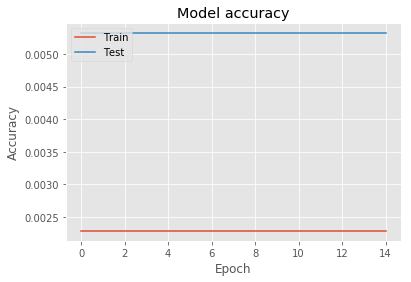

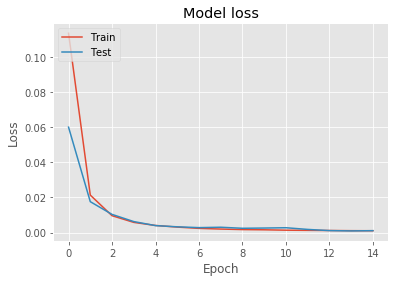

In [84]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Graphique très particulier du la précision du modèle. La metric est sans doute à revoir.

In [135]:
Start_Keras_pred = datetime.now()
pred_keras = model.predict(X_test)
Temps_Keras_pred = datetime.now() - Start_Keras_pred
Keras_pred = scalarY.inverse_transform(pred_keras)

In [141]:
#Temps Pred Keras
print(str(Temps_Keras_pred))

0:00:00.274634


In [86]:
score = model.evaluate(X_test, y_test_Keras)
score

313/313 [==============================] - 0s 36us/step


[0.0017084753053030744, 0.0]

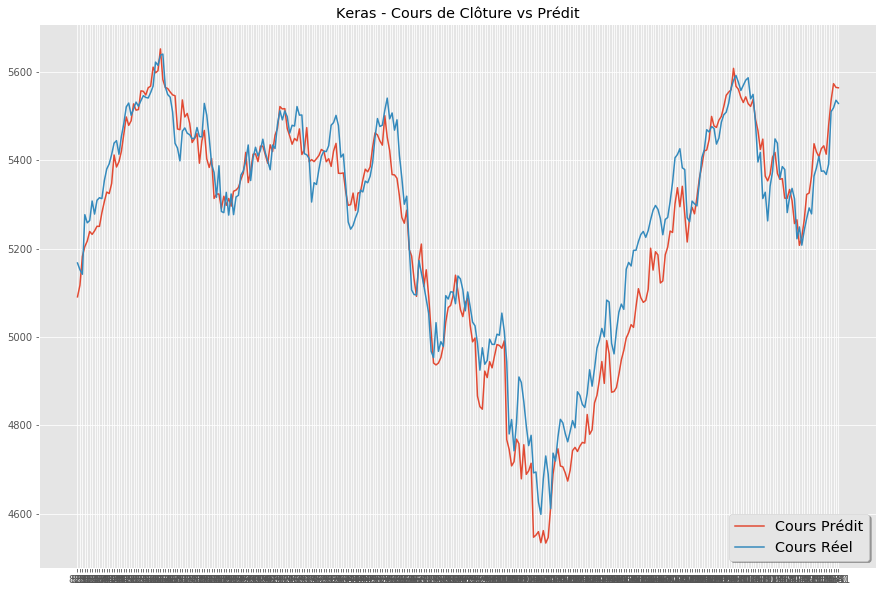

In [87]:
plt.figure(figsize=(15,10))
plt.plot(Keras_pred,label ='Cours Prédit')
plt.plot(y_test,label='Cours Réel')
plt.title('Keras - Cours de Clôture vs Prédit')
plt.legend(loc='lower right', shadow=True, fontsize='x-large')

Le modèle semble avoir du mal à determiner certaine tendance, se positionnant souvent sur des tendances plus faible que la réalité.

- ### Xgboost

XGBoost est une implémentation open source optimisée de l’algorithme d’arbres de boosting de gradient.

Principe : 

Le Boosting de Gradient est un algorithme d’apprentissage supervisé dont le principe et de combiner les résultats d’un ensemble de modèles plus simple et plus faibles afin de fournir une meilleur prédiction. 

L’algorithme travaille de manière séquentielle, cette façon de faire va le rendre plus lent bien sur mais il va surtout permettre à l’algorithme de s’améliorer par capitalisation par rapport aux exécutions précédentes. Il commence donc par construire un premier modèle qu’il va évaluer (on est bien sur de l’apprentissage supervisé). A partir de cette première évaluation, chaque individu va être alors pondérée en fonction de la performance de la prédiction.

In [138]:
xgb_model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.3,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6
                 )
Start_xgb = datetime.now()
xgb_model.fit(X_train,y_train)
Temps_xgb = datetime.now() - Start_xgb


Start_xgb_pred = datetime.now()
xgb_pred = xgb_model.predict(X_test)
Temps_xgb_pred = datetime.now() - Start_xgb

/Users/yoan/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/yoan/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[20:11:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [139]:
# Temps Training de Xgboost
str(Temps_xgb)

'0:00:07.552101'

In [140]:
#Temps Pred Xgboost
print(str(Temps_xgb_pred))

0:00:07.580323


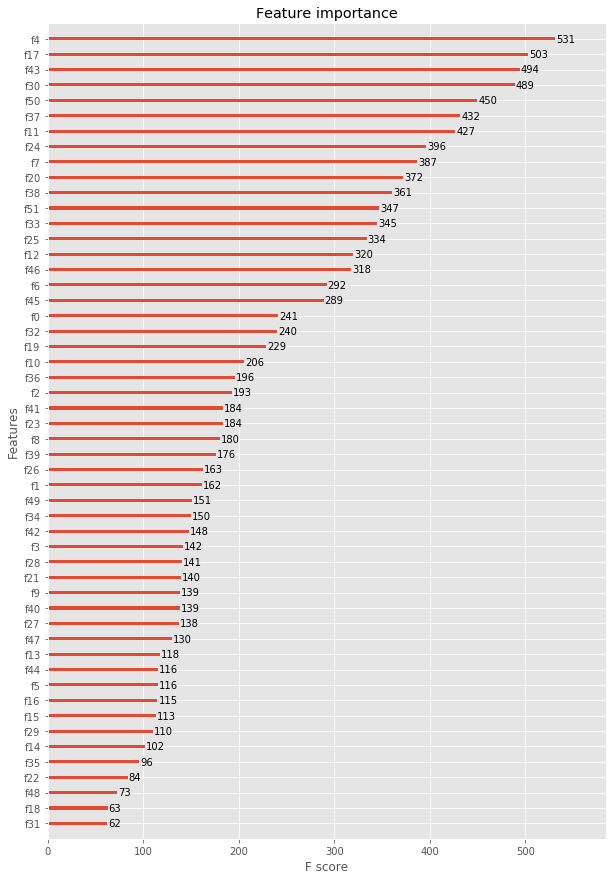

In [52]:
ax = xgb.plot_importance(xgb_model)
fig = ax.figure
fig.set_size_inches(10, 15)


On remarque que notre variable la plus importante dans le modèle est la F4 : Close J-1, ce qui n'est pas supprenant, vient ensuite la F17 : Close J-2, ainsi de suite...

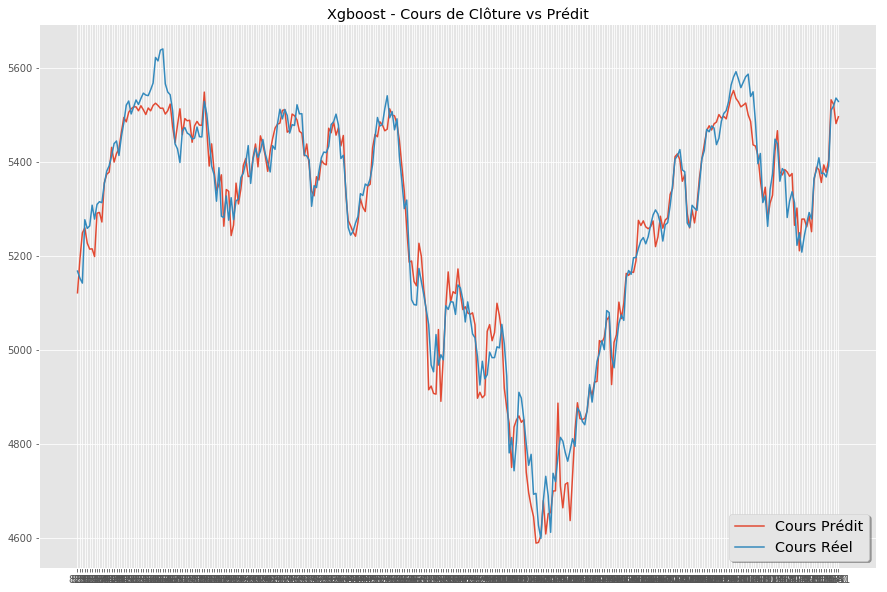

In [53]:
plt.figure(figsize=(15,10))
plt.plot(xgb_pred,label='Cours Prédit')
plt.plot(y_test,label='Cours Réel')
plt.title('Xgboost - Cours de Clôture vs Prédit')
plt.legend(loc='lower right', shadow=True, fontsize='x-large')

- ### Mix Keras & Xgboost

Afin de gagner en stabilité et en précision générale, il est souvent interessant de coupler des modèles et de jouer sur l'hyperparamétrabilité de ces derniers.
Une regression logisitique est généralement utilisée dans le but de déterminer les poids des modèles afin de gagner en précision.

In [88]:
Mix_pred = (np.concatenate(Keras_pred, axis=0) + xgb_pred) /2

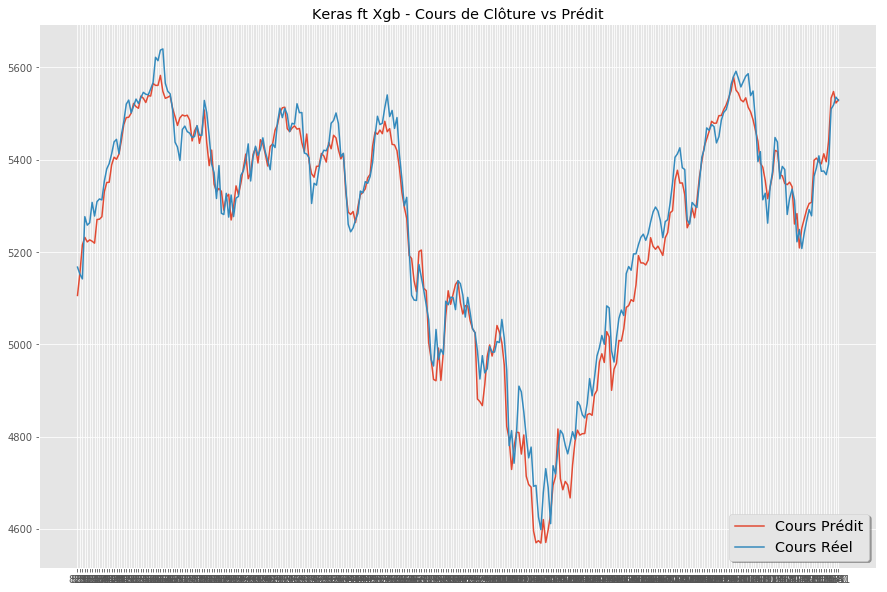

In [89]:
plt.figure(figsize=(15,10))
plt.plot(Mix_pred,label='Cours Prédit')
plt.plot(y_test,label='Cours Réel')
plt.title('Keras ft Xgb - Cours de Clôture vs Prédit')
plt.legend(loc='lower right', shadow=True, fontsize='x-large')

Normalement, je créerais une boucle afin de tester de multiple paramètres afin d'affiner les résultats et de coupler plusieurs modèles mais ce n'est pas le but de cet exemple.

----
### 6. Choix du Modèle et Interprétation <a id="A6"></a>
-----


In [157]:
def précision (prediction,reelle):
    return 100 - np.mean(abs((prediction - reelle)/reelle)*100)

def diff_moy(prediction,reelle):
    return np.mean(abs(prediction-reelle))

In [158]:
Nom_modèle = ['Keras','Xgb','Keras+Xgb']
Précision = [précision(np.concatenate(Keras_pred, axis=0),y_test),précision(xgb_pred,y_test),précision(Mix_pred,y_test)]
Diff_moy = [diff_moy(np.concatenate(Keras_pred, axis=0),y_test),diff_moy(xgb_pred,y_test),diff_moy(Mix_pred,y_test)]
Temps_Training = [str(Temps_Keras),str(Temps_xgb),str(Temps_xgb+Temps_Keras)]
Temps_Pred = [str(Temps_Keras_pred),str(Temps_xgb_pred),str(Temps_xgb_pred+Temps_Keras_pred)]

In [163]:
ar = np.array([Précision,Diff_moy,Temps_Training,Temps_Pred])
result = pd.DataFrame(ar, index = ['Précision %', 'Volatilité Moyenne','Temps Entrainement', 'Temps Prédiction'], columns = Nom_modèle)
result

,Keras,Xgb,Keras+Xgb
Précision %,97.80927829796593,99.3429808844409,99.30914929428992
Volatilité Moyenne,115.02884291383786,34.17137111871006,35.78940726088259
Temps Entrainement,0:00:02.127347,0:00:07.552101,0:00:09.679448
Temps Prédiction,0:00:00.274634,0:00:07.580323,0:00:07.854957


Il semblerait que le modèle XGB soit, pour un léger coût de temps supplémentaire, clairement plus performant que Keras. Néanmoins, nous remarquons un résultat intéressant du mix de seulement 2 modèles. Cependant, mettons cela en perspective : 

- ### Interprétation

In [166]:
# Volatilité moyenne
np.mean(abs(df['Close J-1'] - df['Open J-1']))

29.083952373928494

Si l'on ne regarde que la précision de % des modèles on peut se dire 99,34% est très bien, cependant si on le remet en contexte une erreur de 0,7% sur la valeur du CAC40 représente une variation de 34,17€, ce qui est bien plus que la volatilité moyennne du jeu de données.

Notre modèle va donc tendre dans l'amplification des tendances ou ne pas détecter des pics, comme en vert si dessous.

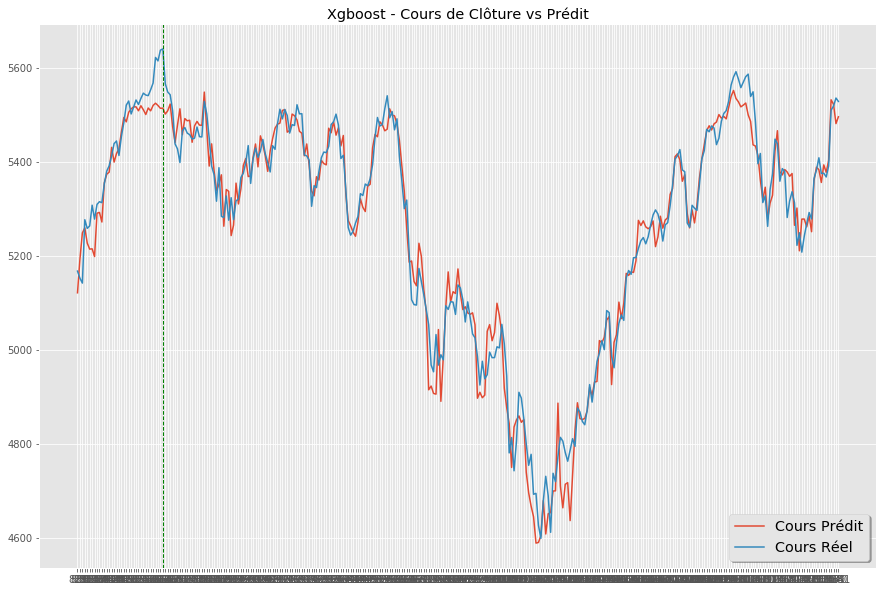

In [174]:
plt.figure(figsize=(15,10))
plt.plot(xgb_pred,label='Cours Prédit')
plt.plot(y_test,label='Cours Réel')
plt.axvline(35, linewidth=1, color='g', linestyle='dashed')
#plt.axvline('2015-10-23', linewidth=1, color='r', linestyle='dashed')
plt.title('Xgboost - Cours de Clôture vs Prédit')
plt.legend(loc='lower right', shadow=True, fontsize='x-large')

[Retour en Haut](#Top) 